### Summary
1. Enable data augmentation, and precompute = True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for several epochs
4. Train last later with data augmentation (precompute = False) for another several epochs with cycle_len = 1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult = 2 until over-fitting

In [0]:
#Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt


In [0]:
PATH = 'fastai/data/dogscats/'
sz = 224

In [0]:
arch = resnet34
# flip sideways, vary the contrast, blur, zoom-in
tfms = tfms_from_model(resnet34, 
                       sz, 
                       # transform_top_down: flip vertically
                       # transform_side_on: flip horizontally
                       aug_tfms = transforms_side_on,
                       max_zoom = 1.1)

#### Data Augmentation

In [0]:
def get_augs():
  data = ImageClassifierData.from_paths(PATH, 
                                        bs = 2, 
                                        tfms = tfms, 
                                        num_workers = 1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

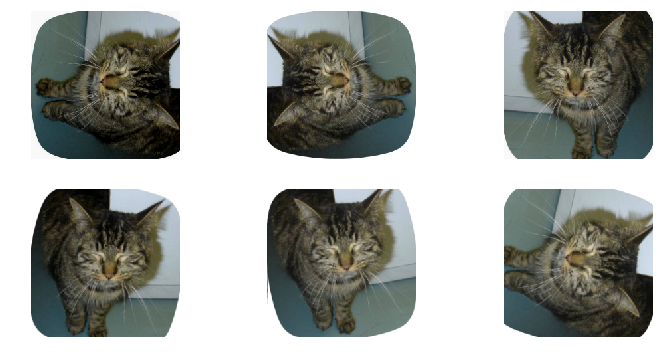

In [48]:
plots(ims, rows = 2)

In [50]:
# Create a new data object with augmented data included
data = ImageClassifierData.from_paths(PATH, tfms = tfms)

# when precompute = True, data augmentation not work
learn = ConvLearner.pretrained(arch, data, precompute = True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 83469812.43it/s]


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


#### Model Training

In [51]:
# This learning has no data augmentation included
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.052212   0.028206   0.9895    



[array([0.02821]), 0.9895]

In [52]:
# set precompute = False and learn again
# This time augmented data is included
learn.precompute = False

# cycle_len = 1
# [learning rate (cosine) annealing] decrease learning rate with iterations
# reset learning rate to its peak at every epoch
# gradually decrease learning rate for each minibatch
# Note that we are training the last layer (randomly initialized)
learn.fit(1e-2, 3, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.16521    0.037614   0.9865    
    1      0.153711   0.036437   0.988     
    2      0.149394   0.03481    0.9875    



[array([0.03481]), 0.9875]

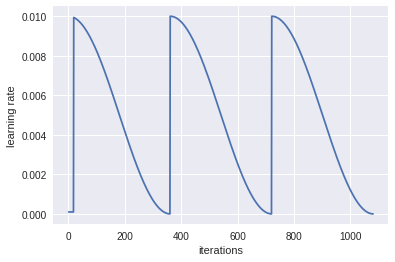

In [53]:
learn.sched.plot_lr()

In [0]:
# save the model
# It is saved in {PATH}/models
learn.save('224_lastlayer')
# load in the model
learn.load('224_lastlayer')

#### Fine-tunning and Differential Learning Rate Annealing

Sometimes we don't want to re-train the activation features/ filters. The most shallow layer represent pretty general features, such as corner and edge. They capture very general geometric pattern. As for deeper layer, it captures more context specific features. In case the pretrain model has greatly different feature from you input image. You may need to learn new activation features, gradient edges based on the pretrained result. On the other hand, we need to fine-tune the weights carefully so as to avoid a worse performance. This session goes through how to change the activation filter.

In [0]:
# unfreeze the remaining layers
# unfreeze layer from n onwards
learn.unfreeze()

In [0]:
# The most shallow layers need little training
# The deepest layers need more training
# shallow > middle > deep
lr = np.array([1e-4, 1e-3, 1e-2])

In [62]:
# stochastics gradient descent: cycle_len = 1
# number of cycles = 3
# each cycle contains 2 epoch
# cycle_mult = 2 - Double the length of cycle for each cycle
# 1 + 2 + 4 epochs
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.123078   0.033801   0.988     
    1      0.08697    0.032333   0.9875    
    2      0.075354   0.030468   0.9875    
    3      0.086779   0.033688   0.9865    
    4      0.058987   0.031271   0.986     
    5      0.063873   0.0291     0.9885    
    6      0.054152   0.028828   0.989     



[array([0.02883]), 0.989]

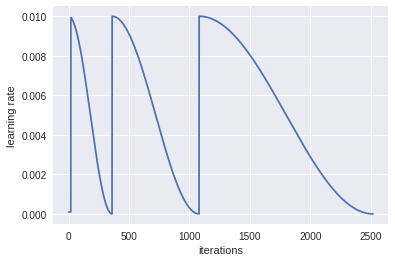

In [63]:
learn.sched.plot_lr()

#### Test Time Augmentation
In short, Test Time Augmentation(TTA) is a technique used in prediction on test set based on the idea of data augmention. The technique generate a collections of augmented images and give predictions for each. It could potentially boost the model performance. 

In [0]:
learn.save('224_all')
learn.load('224_all')

In [0]:
# accuracy/ accuracy_np from fastai doesn't work
def accuracy_custom(preds, tags):
  preds_tags = np.argmax(preds,1)
  n = len(preds)
  return sum(preds == tags)/n

In [0]:
# validation set performance with TTA
# By default it is applied on validation set
log_preds, y = learn.TTA()

In [111]:
# Soft ensemble to aggregate augmented results
probs = np.mean(np.exp(log_preds), 0)
accuracy_custom(probs, y)

0.991

In [101]:
# test set performance without TTA
log_preds_woTTA = learn.predict()
accuracy_custom(log_preds_woTTA, y)

0.989

#### Result Analysis

In [113]:
# Construct confusion matrix
preds = np.argmax(probs, axis = 1)

array([0, 0, 0, ..., 1, 1, 0])

In [0]:
preds_woTTA = np.argmax(log_preds_woTTA, 1)

[[993   7]
 [ 11 989]]


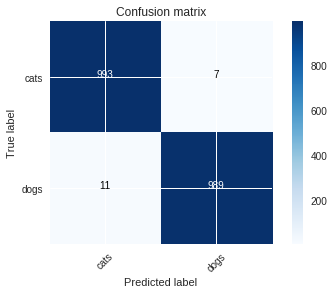

In [114]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

[[991   9]
 [ 13 987]]


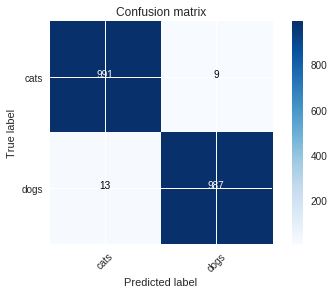

In [117]:
cm_woTTA = confusion_matrix(y, preds_woTTA)
plot_confusion_matrix(cm_woTTA, data.classes)